In [3]:
import pathlib
import sys

sys.path.append("../")

local_path = pathlib.Path().resolve()
local_path

WindowsPath('C:/Users/NielsOta/Code/StateSpace/statespace')

In [4]:
import torch
import pathlib

from typing import List, Optional, Dict, Tuple
from torch.autograd import Variable
from scipy.optimize import minimize
from collections import deque

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from utils import _mm, _bmm, _inv, _mm3, _bmm3, _initiate_variables, _map_vector_to_matrices, _get_nan_positions, _remove_nan_tensor, _remove_inf_tensor, _get_bounds

In [6]:
# Will be forward method

def _kalman_step(T, Z, R, Q, H, a, P, y):
    """
    perform 1 step of the kalman filter
    """
    
    # prediction error: v
    v = y - _mm(Z, a)
    
    # prediction error variance: F
    F = _mm3(Z, P, Z.T) + H
    
    # incast-kalman gain: M
    M = _mm3(P, Z.T, _inv(F)) 
    
    # kalman gain: K
    K = _mm(T, M)
    
    # incasted updates
    att = a + _mm(M, v)
    Ptt = P - _mm3(M, F, M.T)
    
    a_next = _mm(T, att)
    P_next = _mm3(T, Ptt, T.T) + _mm3(R, Q, R.T)
    
    return a_next, P_next, att, Ptt, M, K, F, v

In [7]:
np.eye(1)

array([[1.]])

In [8]:
# Will be forward method

def _kalman_step_missing(T, Z, R, Q, H, a, P, y, dtype=np.float64):
    """
    perform 1 step of the kalman filter when observation is missing
    """
    
    # dimension of observation vector
    s = int(y.shape[0])
    
    # prediction error: v
    v = np.nan
    
    # prediction error variance: F
    F = np.eye(s).astype(dtype) * np.inf
    
    # incast-kalman gain: M
    M = _mm3(P, Z.T, _inv(F).astype(dtype)) 
    
    # kalman gain: K
    K = np.zeros_like(_mm(T, M))
    
    # incasted updates
    att = a
    Ptt = P
    
    a_next = _mm(T, att)
    P_next = _mm3(T, Ptt, T.T) + _mm3(R, Q, R.T)
    
    return a_next, P_next, att, Ptt, M, K, F, v

In [9]:
def kalman_filter(*args):
    """
    perform all the steps of the Kalman filter
    """
    T, Z, R, Q, H, y, diffuse, shapes = args
    
    # number of observations
    n = shapes['n']
    
    # dimension of state vector
    p = shapes['p']

    # dimension of observation vector
    s = shapes['s']
    
    # initiate filters (a, att), filter variances (P, Ptt), errors (v), error variances (F), and Kalman gains (K, M)
    a, att, _, P, Ptt, _, v, F, K, M = _initiate_variables(p, s, n)
    
    # get positions of missing observations
    nan_pos_list = _get_nan_positions(y)
    
    # do a diffuse initialization
    if diffuse:
        a[:, :, 0] = 0
        P[:, :, 0] = P[:, :, 0] + 1e5 * np.eye(p, p)

    # iterate through time
    for t in range(1, n):
        
        if t-1 not in nan_pos_list:
            # a[0] contains a1, y[0] contains y1
            y_t = y[:, :, t-1]
            a[:, :, t], P[:, :, t], att[:, :, t-1], Ptt[:, :, t-1], M[:, :, t-1], K[:, :, t-1], F[:, :, t-1], v[:, :, t-1] = _kalman_step(T[:, :, t-1], Z[:, :, t-1], R[:, :, t-1], Q[:, :, t-1], H[:, :, t-1], a[:, :, t-1], P[:, :, t-1], y_t)
        
        else:
            y_t = y[:, :, t-1]
            a[:, :, t], P[:, :, t], att[:, :, t-1], Ptt[:, :, t-1], M[:, :, t-1], K[:, :, t-1], F[:, :, t-1], v[:, :, t-1] = _kalman_step_missing(T[:, :, t-1], Z[:, :, t-1], R[:, :, t-1], Q[:, :, t-1], H[:, :, t-1], a[:, :, t-1], P[:, :, t-1], y_t)
    
    if n-1 not in nan_pos_list:
        # do final incasting update
        y_t = y[:, :, n-1]
        _, _, att[:, :, n-1], Ptt[:, :, n-1], M[:, :, n-1], K[:, :, n-1], F[:, :, n-1], v[:, :, n-1] = _kalman_step(T[:, :, t-1], Z[:, :, t-1], R[:, :, t-1], Q[:, :, t-1], H[:, :, t-1], a[:, :, n-1], P[:, :, n-1], y_t)
    
    else:
        # do final incasting update
        y_t = y[:, :, n-1]
        _, _, att[:, :, n-1], Ptt[:, :, n-1], M[:, :, n-1], K[:, :, n-1], F[:, :, n-1], v[:, :, n-1] = _kalman_step_missing(T[:, :, t-1], Z[:, :, t-1], R[:, :, t-1], Q[:, :, t-1], H[:, :, t-1], a[:, :, n-1], P[:, :, n-1], y_t)
    
    return a, att, P, Ptt, F, v, K, M 


def kalman_forecast(*args, time=10, dtype=np.float64):
    """
    forecast 
    """
    T, Z, R, Q, H, att, Ptt, shapes = args
    
    # number of observations
    n = shapes['n']
    
    # dimension of state vector
    p = shapes['p']

    # dimension of observation vector
    s = shapes['s']
    
    # initiate filters (a, att), filter variances (P, Ptt), errors (v), error variances (F), and Kalman gains (K, M)
    a_forecast, P_forecast = np.zeros((p, 1, time + 1)).astype(dtype), np.zeros((p, p, n)).astype(dtype)
    a_forecast[:,:,0], P_forecast[:,:,0] = att[:, :, -1], Ptt[:, :, -1]
    
    for t in range(1, time + 1):
        a_forecast[:,:,t] = _mm(T, a_forecast[:,:,t-1])
        P_forecast[:,:,t] = _mm3(T, P_forecast[:,:,t-1], T.T) + _mm3(R, Q, R.T)
    
    return a_forecast[:,:,1:], P_forecast[:,:,1:]


def kalman_smoother(*args, dtype=np.float64):
    """
    perform Kalman smoothing
    """
    T, Z, R, Q, H, a, P, v, F, K, shapes = args
    
    # number of observations
    n = shapes['n']
    
    # dimension of state vector
    p = shapes['p']

    # dimension of observation vector
    s = shapes['s']
    
    # instantiate a_hat
    a_hat = np.zeros_like(a)
    
    # L' = (T - KZ)'
    L = T - np.einsum('ijn,jkn->ikn', K, Z)
    
    # r[n+1] = r_n = 0
    r = np.zeros((p, 1, n + 1)).astype(dtype)
    
    # a[0] contains a_1, y[0] contains y_1
    
    # from 99...0
    for t in range(n-1, -1, -1):
        
        if np.isnan(v[:, :, t]):
             r[:, :, t] =  r[:, :, t+1]
        else:
            r[:, :, t] = _mm3(Z[:, :, t].T, _inv(F[:, :, t]), v[:, :, t]) + _mm(L[:, :, t].T, r[:, :, t+1])
    
        a_hat[:, :, t] = a[:, :, t] + _mm(P[:, :, t], r[:, :, t])
        
    return a_hat, r, L

def log_likelihood(params, *args):
    
    T, Z, R, Q, H, y, param_map, diffuse, shapes = args
    T, Z, R, Q, H = _map_vector_to_matrices(params, param_map, T, Z, R, Q, H)
    
    # get means and variances
    _, _, _, _, F, v, _, _  = kalman_filter(T, Z, R, Q, H, y, diffuse, shapes)
    
    if diffuse:
        num_states = T.shape[0]
        F = F[:, :, num_states:]
        v = v[:, :, num_states:]
    
    # If an observation at time t is not present, should not include in log-likelihood
    v = _remove_nan_tensor(v)
    F = _remove_inf_tensor(F)
    
    # number of observations
    n = shapes['n']
    
    # dimension of state vector
    p = shapes['p']

    # dimension of observation vector
    s = shapes['s']
    
    # get elementwise log determinants log|F|: check docs numpy returns (signs, abs of logdet)
    F_logdets = np.linalg.slogdet(F.transpose(2, 0, 1))
    F_logdets = F_logdets[0] * F_logdets[1]
    
    # get elementwise v'F^(-1)v, then convert shape from [100, 1, 1] -> [100]
    vFv = np.squeeze(_bmm3(v.transpose(2, 1, 0), _inv(F.transpose(2, 0, 1)), v.transpose(2, 0, 1)))
    
    # constant value 
    const = s * np.log(2 * np.pi) * np.ones_like(vFv)
    
    # compute log-likelihood
    llik = -(1/2) * np.sum(const + vFv + F_logdets) 
    
    negative_llik = -llik.item()
    
    return negative_llik

In [10]:
def read_target_from_path(path: pathlib.Path, dtype=np.float64, header=None) -> torch.Tensor:
    
    if not path.exists():
        raise ValueError(f"path: {path} does not exist")
    
    # read data
    data = np.squeeze(pd.read_csv(path, header=header).values)
    
    # if array of shape (n,)
    if data.ndim == 1:
        data = data[:, np.newaxis]
    
    n = data.shape[0]
    p = data.shape[1]
    
    y = data.T
    y = y[:, None, :]
  
    return y.astype(dtype)

In [11]:
from dataclasses import dataclass

In [12]:
@dataclass
class LinearGaussianModel:
    
    """
    class implementing a linear Gaussian model in StateSpace form
    
        y_t         = Z_t * alpha_t +       epsilon_t        epsilon_t ~ N(0, H_t)
        alpha_{t+1} = T_t * alpha_t + R_t * eta_t            eta_t ~ N(0, Q_t)
        
    """
    
    # Declare observation vector
    y: np.ndarray
    
    # Declare State Matrices 
    T: np.ndarray
    Z: np.ndarray
    R: np.ndarray
    Q: np.ndarray
    H: np.ndarray
        
    # Declare whether init is diffuse
    diffuse: bool
    
    # Declare map for mapping param vector of optimizer to state matrices; e.g. 0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (None, None)}
    param_map: Dict[int, Dict]
    
    # Declare map for mapping each row of filters to its role {'0': level, '1': trend, '2': season}
    filter_map: Dict[int, Dict]
        
    def __post_init__(self):
        
        # Get p, s, n: dimension state, dimension observation and length of y (time)
        self.p = self.T.shape[0]
        self.s = self.y.shape[0]
        self.n = self.y.shape[2]
        self.shapes = {'p': self.p, 's': self.s, 'n': self.n}
        
        # Check that shapes match
        assert self.__check_shapes(self.T, self.Z, self.R, self.Q, self.H)
        
        # Add time dimension to state matrices
        self.__3Dfy_state_matrices()
        
        # Get filteres (line 1), filter variances (line 2), error and error variance (line 3) signals and Kalman gains
        self.a, self.att, self.a_hat, self.P, self.Ptt, self.P_hat, self.v, self.F, self.K, self.M = _initiate_variables(self.p, self.s, self.n)
    
    def __get_state_matrices(self):
        return self.T, self.Z, self.R, self.Q, self.H
    
    def __set_state_matrices(self, *args):
        T, Z, R, Q, H = args
        self.__check_shapes(T, Z, R, Q, H)
        self.T, self.Z, self.R, self.Q, self.H = T, Z, R, Q, H
    
    def __3Dfy_state_matrices(self):
        """
        takes 2D state matrices and turns into 3D state matrices
        """
        
        shapes = self.__get_shapes()
        n = shapes['n']
        names = ['T', 'Z', 'R', 'Q', 'H']
        
        TwoD_matrices = [*self.__get_state_matrices()]
        
        # use i..range to edit elements in list
        for i in range(len(TwoD_matrices)):
            if TwoD_matrices[i].ndim == 2:
                TwoD_matrices[i] = np.repeat(TwoD_matrices[i][:, :, None], n, axis=2)
            else:
                if TwoD_matrices[i].shape[2] != n:
                    raise ValueError(f' #depth of {names[i]} is {TwoD_matrices[i].shape[2]} and not {n})')
        
        # update into 3D matrices
        self.__set_state_matrices(*TwoD_matrices)      
    
    def __get_filters(self):
        return self.a, self.att, self.a_hat, self.P, self.Ptt, self.P_hat, self.v, self.F, self.K, self.M
    
    def __get_shapes(self):
        return self.shapes
    
    def __get_filter_map(self):
        return filter_map
    
    def __check_shapes(self, T, Z, R, Q, H):
        
        # check that T is square
        if not T.shape[0] == T.shape[1]:
            raise ValueError(f'T not a square square matrix ({T.shape[0]}x{T.shape[1]})')
        
        # check that Q is square
        if not Q.shape[0] == Q.shape[1]:
            raise ValueError(f'Q not a square square matrix ({Q.shape[0]}x{Q.shape[1]})')
        
        # check that H is square
        if not H.shape[0] == H.shape[1]:
            raise ValueError(f'H not a square square matrix ({H.shape[0]}x{H.shape[1]})')
        
        # check that columns of R is rows of Q
        if not R.shape[1] == Q.shape[0]:
            raise ValueError(f' #columns of R not #rows of Q ({R.shape[1]} and {Q.shape[0]})')
            
        # check that rows of T is rows of R
        if not T.shape[0] == R.shape[0]:
            raise ValueError(f' #rows of T not #rows of R ({T.shape[0]} and {R.shape[0]})')
        
        return True
    
    def fit(self):
        
        # Get State Matrices 
        T, Z, R, Q, H = self.__get_state_matrices()

        # Get whether init is diffuse
        diffuse = self.diffuse

        # Get map for mapping param vector of optimizer to state matrices
        param_map= self.param_map

        # Get observation vector
        y = self.y
        
        # Get shapes
        shapes = self.shapes
        
        # set options for minimization
        options = {
            'eps': 1e-8,
            'disp': True,
            'maxiter': 2000
        }
        
        # Get bounds for optimization
        bounds = _get_bounds(param_map)
        
        params_ini = np.ones((len(param_map), 1))
        
        # maximize log-likelihook
        res = minimize(log_likelihood, params_ini, args=(T, Z, R, Q, H, y, param_map, diffuse, shapes), method='L-BFGS-B', options=options, bounds=bounds)
        
        # extract params
        params = res.x
        
        # Update instance state matrices
        T, Z, R, Q, H = _map_vector_to_matrices(params, param_map, T, Z, R, Q, H)
        self.T, self.Z, self.R, self.Q, self.H = T, Z, R, Q, H
        
        # Get filtered and incasted signals and signal variances, 
        a, att, P, Ptt, F, v, K, M  = kalman_filter(T, Z, R, Q, H, y, diffuse, shapes)
        self.a, self.att, self.P, self.Ptt, self.v, self.F, self.K, self.M = a, att, P, Ptt, F, v, K, M 
        
        # Get smoothed signal
        a_hat, r, L = kalman_smoother(T, Z, R, Q, H, a, P, v, F, K, shapes)
        self.a_hat, self.r, self.L = a_hat, r, L
        
    
    def plot_states(self, signal_components=None, state_only=False):
        """
        ONLY WORKS FOR SCALAR y_t, not yet implemented for vectors 
        
        """
        
        # get filters for plotting
        a, att, a_hat, P, Ptt, P_hat, F, v, K, M = self.__get_filters()
        
        # get system matrices
        T, Z, R, Q, H = self.__get_state_matrices()
        
        # get shapes
        filter_map = self.__get_filter_map()
        filter_names = list(filter_map.values())
        filter_keys = list(filter_map.keys())
        
        # if no signal passed, assume level at index 0
        if not signal_components:
            print('assuming component at index 0 is main component of y')
        signal_components = signal_components if signal_components else [filter_map[0]]
        
        # check if components in signal are in fact part of filters
        for component in signal_components:
            if not component in filter_names:
                raise ValueError(f'{component} not part of signal')
                
        # get indices of components passed to signal argument
        indxs = []
        for component in signal_components:
            index = filter_names.index(component)
            indxs.append(filter_keys[index])
        
        # number of plots is 1 (includes obeservations) + 1 for each filter in filter_map
        nfilters = len(filter_map.keys())
        num_plots = nfilters + 1
        
        # get z, y and a_hat in correct shape
        Z = np.squeeze(Z)
        y = np.squeeze(self.y)
        a_hat = np.squeeze(a_hat)
        
        # create plot 
        fig, axs = plt.subplots(num_plots, sharex=True)
        fig.set_size_inches(10, 10)
        
        axs[0].set_title('Observation + Level (at index 0)')
        axs[0].plot(range(len(y)), y)
        axs[0].grid()
        
        # machanics of slicing depends on number of states
        if nfilters == 1:
            if not state_only:
                axs[0].plot(Z * a_hat)
            else:
                axs[0].plot(a_hat)
        else:
            if not state_only:
                print(f'here, using z and indxs: {indxs}')
                signal = np.sum([Z[i, :] * a_hat[i, :] for i in indxs], axis=0)
                axs[0].plot(signal)
            else:
                signal = np.sum([a_hat[i, :] for i in indxs], axis=0)
                axs[0].plot(signal)
        
        # for each plot, plot the row of a_hat given in filter_map with the given title
        for idx, i in enumerate(filter_map.keys()):
            
            axs[idx + 1].set_title(filter_map[i])
            axs[idx + 1].grid()
            
            if nfilters == 1:
                axs[idx + 1].plot(a_hat)
            else:
                axs[idx + 1].plot(a_hat[i, :])
        

In [13]:
@dataclass
class LLM(LinearGaussianModel):
    
    def __init__(self, y):
        
         # Declare State Matrices Local Level Model -> use [[]] for extra dimension
        T = np.array([[1]]).astype(dtype)
        Z = np.array([[1]]).astype(dtype)
        R = np.array([[1]]).astype(dtype)
        Q = np.array([[1]]).astype(dtype)
        H = np.array([[1]]).astype(dtype)
        diffuse = True

        dict_param_llm = {
            0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
            1:  {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
        }
        
        filter_map = {0: "level"}
        
        super().__init__(y, T, Z, R, Q, H, diffuse, dict_param_llm, filter_map)

# Local Level Using General Formulation

assuming component at index 0 is main component of y


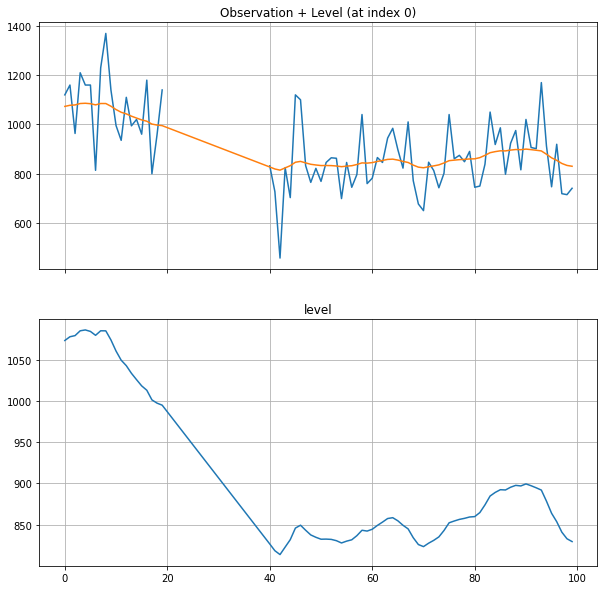

In [14]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(nile_path, dtype, header='infer')
y[:, :, 20:40] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
R = np.array([[1]]).astype(dtype)
Q = np.array([[1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llm = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1:  {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level"}

llm = LinearGaussianModel(y, T, Z, R, Q, H, diffuse, dict_param_llm, filter_map)
llm.fit()
llm.plot_states()

# Local Level Using LLM Child class

assuming component at index 0 is main component of y


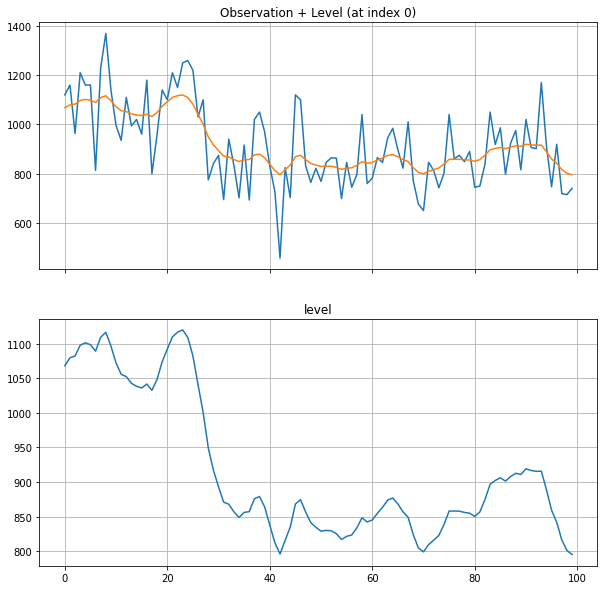

In [15]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
nile_path = data_dir / 'Nile.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(nile_path, dtype, header='infer')
#y[:, :, 20:40] = np.nan

llm = LLM(y)
llm.fit()
llm.plot_states()

# Local Linear Trend Using General Formulation

assuming component at index 0 is main component of y
here, using z and indxs: [0]


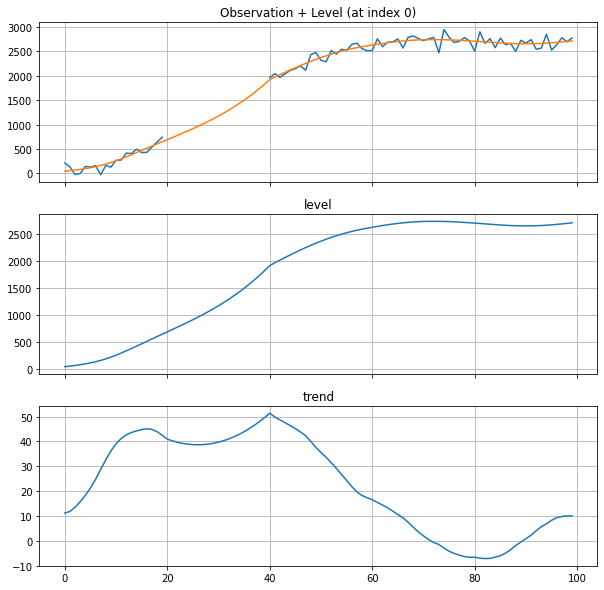

In [16]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llt.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
y[:, :, 20:40] = np.nan

# Declare State Matrices Local linear Trend Model -> use [[]] for extra dimension
T = np.array([[1, 1], [0, 1]]).astype(dtype)
Z = np.array([[1, 0]]).astype(dtype)
R = np.array([[1, 0], [0, 1]]).astype(dtype)
Q = np.array([[1, 0], [0, 1]]).astype(dtype)
H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llt = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend"}

llt = LinearGaussianModel(y, T, Z, R, Q, H, diffuse, dict_param_llt, filter_map)
llt.fit()
llt.plot_states()

# Local Linear Trend w/ Seasonal Component

here, using z and indxs: [0, 2]


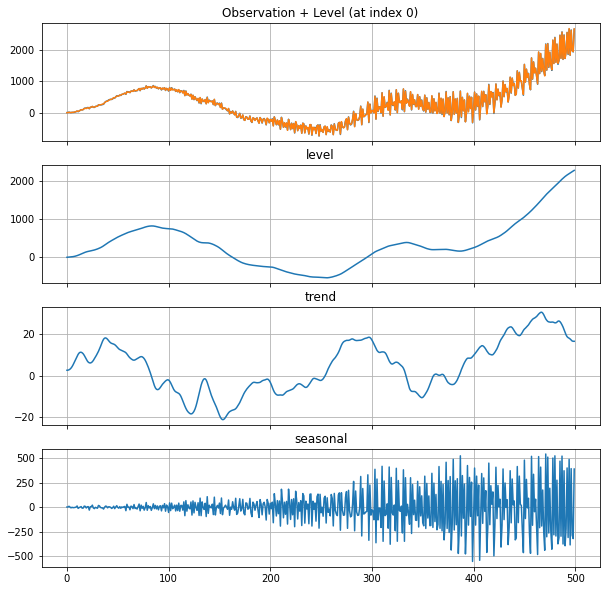

In [17]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
llt_path = data_dir / 'llts.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(llt_path, dtype)
#y[:, :, 400:500] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1], 
              [0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0]]).astype(dtype)

R = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0], 
              [0, 0, 0]]).astype(dtype)

Q = np.array([[1, 0, 0], 
              [0, 1, 0], 
              [0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llts = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal"}

llts = LinearGaussianModel(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
llts.fit()
llts.plot_states(signal_components=['level', 'seasonal'])

here, using z and indxs: [0]


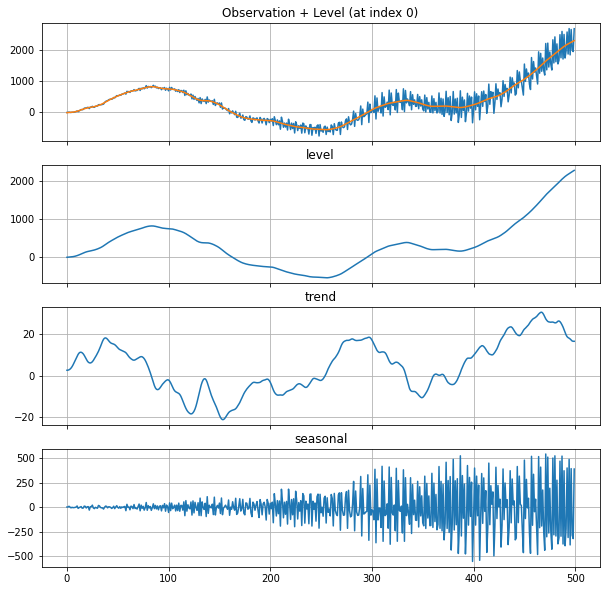

In [18]:
llts.plot_states(signal_components=['level'])

# Local Linear Trend w/ Seasonal Component and Exogenous Regressor

here, using z and indxs: [0, 2]


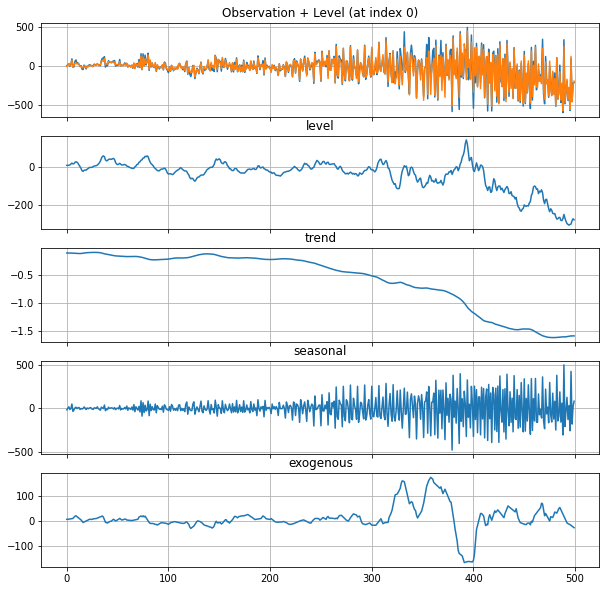

In [19]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
lltsx_path = data_dir / 'lltsX.txt'
regressor_path = data_dir / 'regressor.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(lltsx_path, dtype)
X = read_target_from_path(regressor_path, dtype)
# y[:, :, 400:500] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0, 0, 0, 0], 
              [0, 0, -1, -1, -1, -1, -1, -1, 0], 
              [0, 0, 1, 0, 0, 0, 0, 0, 0],
              [0, 0, 0, 1, 0, 0, 0, 0, 0],
              [0, 0, 0, 0, 1, 0, 0, 0, 0], 
              [0, 0, 0, 0, 0, 1, 0, 0, 0], 
              [0, 0, 0, 0, 0, 0, 1, 0, 0],
              [0, 0, 0, 0, 0, 0, 0, 0, 1]]).astype(dtype)

Z = np.array([[1, 0, 1, 0, 0, 0, 0, 0, 1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 8, :] = X 

R = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0], 
              [0, 0, 0, 0],
              [0, 0, 0, 1]]).astype(dtype)

Q = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0], 
              [0, 0, 1, 0],
              [0, 0, 0, 1]]).astype(dtype)

H = np.array([[1]]).astype(dtype)
diffuse = True

dict_param_llts = {
    0: {"matrix" : "Q", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
    1: {"matrix" : "Q", "index": (1, 1, 0), "constant": True, "bounds": (0.1, None)},
    2: {"matrix" : "Q", "index": (2, 2, 0), "constant": True, "bounds": (0.1, None)},
    3: {"matrix" : "Q", "index": (3, 3, 0), "constant": True, "bounds": (0.1, None)},
    4: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)}
}

filter_map = {0: "level", 1: "trend", 2: "seasonal", 8: "exogenous"}

lltsX = LinearGaussianModel(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=['level', 'seasonal'])

here, using z and indxs: [0, 2, 8]


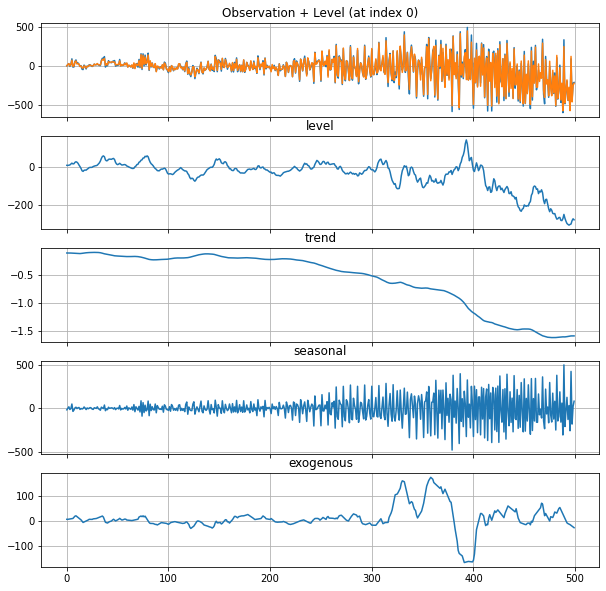

In [20]:
lltsX.plot_states(signal_components=['level', 'seasonal', 'exogenous'])

# Regression

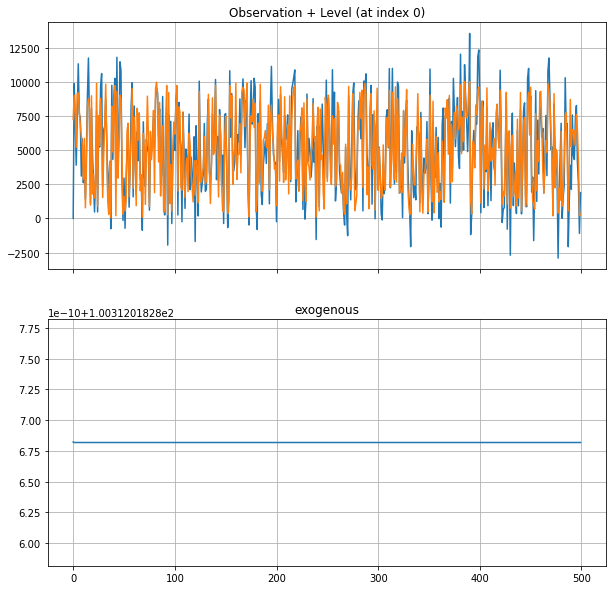

In [31]:
dtype=np.float64
base_dir = pathlib.Path().resolve().parent
data_dir = base_dir / 'data'
y_path = data_dir / 'standard_regressionY.txt'
x_path = data_dir / 'standard_regressionX.txt'

# get data into shape [s, 1, n]
y = read_target_from_path(y_path, dtype)
X = read_target_from_path(x_path, dtype)
# y[:, :, 400:500] = np.nan

# Declare State Matrices Local Level Model -> use [[]] for extra dimension
T = np.array([[1]]).astype(dtype)
Z = np.array([[1]]).astype(dtype)
Z = np.repeat(Z[:, :, None], 500, axis=2)
Z[0, 0, :] = X 

R = np.array([[1]]).astype(dtype)
Q = np.array([[0]]).astype(dtype)
H = np.array([[1]]).astype(dtype)

diffuse = True

dict_param_llts = {
    0: {"matrix" : "H", "index": (0, 0, 0), "constant": True, "bounds": (0.1, None)},
}

filter_map = {0: "exogenous"}

lltsX = LinearGaussianModel(y, T, Z, R, Q, H, diffuse, dict_param_llts, filter_map)
lltsX.fit()
lltsX.plot_states(signal_components=["exogenous"])

In [32]:
lltsX.a_hat

array([[[100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 100.31201828, 100.31201828, 100.31201828,
         100.31201828, 10